# Period from line shift simulator
We are going to create mock observations in order to simulate the results we would spect from an observing campaing.

First we import the modules we need. 

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from astroML.time_series import  lomb_scargle, lomb_scargle_BIC
from random import SystemRandom

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#import my own library 
import sys
sys.path.append('/Users/noelin/Documents/python_library/')
from time_series_tools import LS_bootstrap_err_est, LS_window_white_noise, LS_null_hypotesis, LS_bootstrap_sig, LS__semi_param_bootstrap_err_est, LS_chi2

The time_series_tools is a personal library I created in order to have all the statistical test functions in the same file. I will coment them below.

Now we define the parameters of the sinusoid we want to model. For this we use the values from the measuremens of the 2017 SpuPNiC campaing:

In [15]:
# =============================================================================
# # setting up parameters
# =============================================================================
A=600 #km/s
frec=4.8# this is an orbital period of 5h
mu_dy= 50.4954382164179041
sig_dy= 4.92449626059060486
np.random.seed(42)         #this is for reproductivity
w=frec*2*np.pi


#Nbins=200 set equal to nfrec downthere
N_bootstraps=int(1e4)

where we are asuming a gaussian distribution of heteroscedastic erros

$\mathrm{frec = P_{orb}^{-1}\ [d^{-1}]}$,

$\mathrm{mu\_dy} = <\vec{\sigma}\ >$,

$\mathrm{sig\_dy = std(\vec{\sigma}\ \ )}$,

Now are ready to generate the data.

## Generating the mock data set
### Time vector
We can generate random observation during for 20 days as follows

In [16]:
# =============================================================================
# # Generate the time vector 
# =============================================================================

seed=SystemRandom()
np.random.seed(seed.randint(0,2**32 - 1)) #activate this for non reproductivity 

##    -----  THIS IS FOR RANDOM OBS    -----
#Nobs=40
#t_obs = 20 * np.random.random(Nobs)  # Nobs observations in 20 days



The observing sample from 2017 campaing is the following:

In [17]:
##My observation simulated
""""
t_obs=np.array([  5.58088318,   5.58839525,   5.59728471,   5.60560702,
         5.61363995,   5.62450871,   5.63207865,   5.63959071,
         5.64742687,   5.65544822,   9.57654344,  10.54443917,
        10.55250679,  10.55997253,  10.56802859,  10.57549432,
        10.5851477 ,  10.59260186,  10.6000676 ,  10.60835515,
        10.61591348,  10.62337922,  10.63304417,  10.6405099 ,  11.59079961])
"""#t_obs-=0.01

'"\nt_obs=np.array([  5.58088318,   5.58839525,   5.59728471,   5.60560702,\n         5.61363995,   5.62450871,   5.63207865,   5.63959071,\n         5.64742687,   5.65544822,   9.57654344,  10.54443917,\n        10.55250679,  10.55997253,  10.56802859,  10.57549432,\n        10.5851477 ,  10.59260186,  10.6000676 ,  10.60835515,\n        10.61591348,  10.62337922,  10.63304417,  10.6405099 ,  11.59079961])\n'

In order to generate more realistic campaign data we can perform several observation per night:

In [18]:
# =============================================================================
# ##ONE RUN PER NIGHT AT MID NIGHT IN UT
# =============================================================================

mu_dt = 0.00802135
sig_dt = 0.00089973033387069634
start_t = 0.55
t_obs = np.linspace(0,34,35) #create one measurement per day 
dt = mu_dt + sig_dt * np.random.random(t_obs.shape) #creating the uncertainty in the measurement
#we can add the (average) shift in time of the twilight for SALT at the month of July
#this willl be from 28sec to 1m30sec, tehrefore we will increase linealry up to 1:30
t_sh_i=28./60/60/24
t_sh_f=90./60/60/24
t_obs += np.linspace(t_sh_i,t_sh_f,35)
# we have to include the shift of the observing window each day
#for this we use the SALT Visibility Calculator 1st july 19:30:16 2nd 18:23:44 3rd 19:19:44
#:19:15:50 and twlight at 7th aug 18 is about 17:25
dt_obs_wind = 2.1/24
t_obs += np.linspace(0,-dt_obs_wind,len(t_obs))
t_obs += start_t + np.random.normal(0,dt) #setting up starting time around mid night 
#dt = 2*mu_dt + sig_dt * np.random.random(t_obs.shape)

"""
#MORE THAN ONE OBS PER NIGHT
n_obs=3 #per night 
t_obs0=t_obs.copy()
for i in range(n_obs-1):
    
    t_obs1 = t_obs0 + np.random.normal(mu_dt,sig_dt/2,len(t_obs0))
    t_obs0 = t_obs1
    t_obs = np.append(t_obs,t_obs1 )
    

# =============================================================================
# ##adding extra night one year later
# =============================================================================
t_obs.sort()
t_obs2=t_obs[:n_obs]
t_obs1 = t_obs2 + np.random.normal(mu_dt,sig_dt/2,len(t_obs2))
t_obs1 += 364.25
t_obs = np.append(t_obs,t_obs1 )

#t_obs2=t_obs[n_obs:2*n_obs]
#t_obs1 = t_obs2 + np.random.normal(mu_dt,sig_dt/2,len(t_obs2))
#t_obs1 += 364.25 + 2
#t_obs = np.append(t_obs,t_obs1 )

"""
Nobs=len(t_obs)

Again we used heteroscedastic erros in the time measurement, they were measured from the las campaign. They correspond to fluctuations in the readout time for consecutive exposures wen we run a MACRO. 

### The data draws
We take the pick the data from the sample (need to introduce some phase shift)

In [19]:
#------------------------------------------------------------
# Generate the data

y_obs1 =A* np.sin(w * t_obs)
dy1 = mu_dy + sig_dy*np.random.random(y_obs1.shape)#np.random.normal(mu_dy,sig_dy,y_obs1.shape)#0.1 + 0.1 * np.random.random(y_obs1.shape)
y_obs1 += np.random.normal(0, dy1)

y_window = np.ones_like(y_obs1)

t = np.linspace(0, np.max(t_obs)+1, np.max(t_obs)*10000)
y =A* np.sin(w * t)

/Users/noelin/anaconda/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


## Periodogram
We compute the periodogram of the actual data and the sampling window for comparation.
 
By default we use the generalized Lomb-Scargle: a modification of the periodogram has variously been called the Date-
compensated Discrete Fourier Transform (Ferraz-Mello 1981), the floating-mean periodogram (Cumming et al. 1999; VanderPlas & Ivezic 2015), or the generalized Lomb-Scargle Method (Zechmeister & Kürster 2009), and involves adding an offset term to the sinusoidal model at each frequency:

$y_{model}(t;f)=y_0(f) + A_f sin(2\pi ft + \phi_f)$      

For the window function we just use the standard Lomb-Scargle

In [20]:
# =============================================================================
# # Compute the periodogram
# =============================================================================
nu = np.linspace(0, 15, 100001)[1:]
omega=nu*(2*np.pi)

P_obs1 = lomb_scargle(t_obs, y_obs1, dy1, omega)
#P_obs2 = lomb_scargle(t_obs, y_obs2, dy2, omega)
P_window = lomb_scargle(t_obs, y_window, 1, omega,
                        generalized=False, subtract_mean=False)

frec_guess=nu[np.argmax(P_obs1)]
frec=frec_guess
P_max=np.max(P_obs1)
P_true=P_max

We can rearange the function above by using the trigonometric identities in order to do a linear regresion to estimate $A_f$ and $\phi_f$

$y_{model}(t;f)=y_0(f) + A_f sin(2\pi ft + \phi_f) = y_0(f)+ a_f sin(\omega t) + b_f cos(\omega t) \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $     (1)

Where $A_f=\sqrt{a_f^2+b_f^2}$ and $\phi_f=arctan(\frac{b_f}{a_f})$

relative error in signal Amplitude
1.0122852905504698
estimated phase
-2.747650842022708


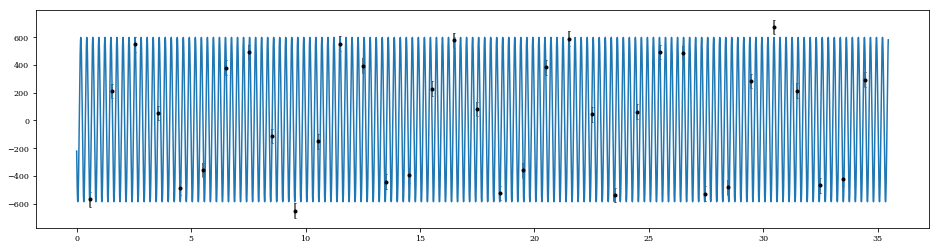

In [21]:
# =============================================================================
# #Fitting the Phase and Amplitude 
# =============================================================================
def bst_sin(frec,a,b,B,t): #we define the best sinusoidal model 
    w=2.*np.pi*frec
    best_sin=a*np.sin(w*t)+b*np.cos(w*t)+B
    return(best_sin)
    
from lmfit import Parameters, minimize
p=Parameters()
#p.add('phase',0., max=np.pi,min=-np.pi) 
p.add('a',0.)   
p.add('b',0.)
p.add('B',0.)   

def residual(p):
    pd=p.valuesdict()
    return bst_sin(frec_guess,pd['a'],pd['b'],pd['B'],np.array(t_obs))-y_obs1

ph_shift = minimize(residual,p,method='Nelder')
A_true=A
A=np.sqrt(ph_shift.params['a']**2+ph_shift.params['b']**2)
phase=np.arctan2(ph_shift.params['b'],ph_shift.params['a'])
B=ph_shift.params['B'].value

f=plt.figure(figsize=(16, 4))
ax1=f.add_subplot(111)
ax1.errorbar(t_obs, y_obs1, dy1, fmt='.k', capsize=1, ecolor='#444444')
ax1.plot(t,A*np.sin((2.*np.pi*frec_guess* t) + phase)+B)
#ax1.plot(t,bst_sin(frec_guess,ph_shift.params['a'],ph_shift.params['b'],ph_shift.params['B'],t))

print('relative error in signal Amplitude')
print(A_true/A)
print('estimated phase')
print(phase)

## Statistical tests

We separate the statistical test in two clases, significance and uncertainty.

With the exception of the $\chi^2$ test, in all the methods we repeat the experiment $10^{x}$ with $x\sim 3-5$ in order to have significant amount of measurements to apply statistics on it. 

### 1. Signal significance
#### 1.1 Bootstrap significance 
This try to disentangle if the estimated period of the signal is due to the sampling function (the window function) rather than the data itself. 

For that reason the method construct the mock sample conserve the original time vector $\vec{t}_{obs}$, the $\vec y\ $ vector is constructed by randomly drawn $y_i$ with repitition. Then compute the periodogram for each mock sample and save the highest peak.

We can compute the significance of the highest peak from the original data by comparing it with the 99% threshold heigh given by the mock sample.

Therefore the idea of this method is to estimate the probability of the best frecuency being a consecuence of the data sampling. 

In [22]:
#bootstrap significance estimation (picking random y from the sample with repitition, same t as before)
D, omegaD = LS_bootstrap_sig(t_obs, y_obs1, dy1, omega, generalized=True,
                           N_bootstraps=N_bootstraps, random_state=None,
                           hist=True,plot_hist=False,Nbins=len(omega))
sig1, sig5 = np.percentile(D, [99, 95])
frecD_BSS=omegaD/(2.0*np.pi)

#### 1.2 Null hypotesis test

Here we try to rull out the hypotesis of the estimated frecuency to be generated by random data.

For this we construct the mock vector component by shuffling all the components in the data set in order to create a fully uncorrelated new vectors from the data we have. As shown in the following example.

<ErrorbarContainer object of 3 artists>

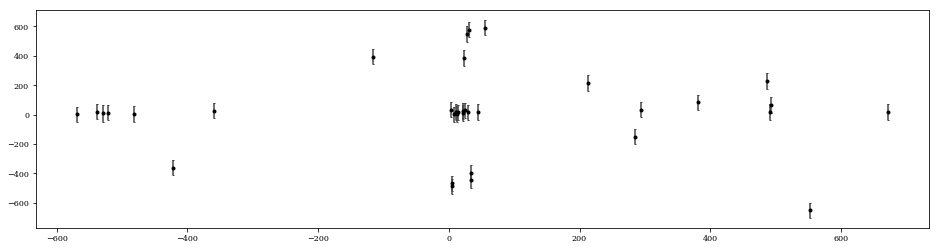

In [23]:
mock_vector=np.append(y_obs1,t_obs)
mock_dy=dy1.copy()
    
np.random.shuffle(mock_vector) 
np.random.shuffle(mock_dy)   

f=plt.figure(figsize=(16, 4))
ax1=f.add_subplot(111)
ax1.errorbar(mock_vector[:len(t_obs)], mock_vector[-len(t_obs):], mock_dy, fmt='.k', capsize=1, ecolor='#444444')

In [29]:
shuff_D, shuff_omegaD =  LS_null_hypotesis(t_obs, y_obs1, dy1, omega, generalized=True,
                           N_mock=N_bootstraps, random_state=None,
                           hist=True,plot_hist=False,Nbins=len(omega))
#frecD_shuff=shuff_omegaD/(2*np.pi) # esto no tiene sentido 
sig1S, sig5S = np.percentile(shuff_D, [99, 95])
frecD_null=shuff_omegaD/(2.0*np.pi)

[ 2.84731843e+01  8.33862957e+01  2.54889166e+01  2.14929172e+01
  6.72436696e+02  2.56395726e+00 -3.59923373e+02  1.05272916e+01
  7.53975246e+00  6.40991619e+01  4.92838129e+02 -5.38207189e+02
  1.45003608e+01  2.64895320e+01  2.94067999e+02  3.04652581e+01
  5.65327652e-01 -5.28674516e+02  1.55087451e+01  3.14705859e+01
  2.94607954e+01  4.87334593e+02  3.93746929e+02 -4.22162553e+02
  3.54321246e+00  2.12622573e+02  3.44624587e+01  2.35009763e+01
  1.15090447e+01  3.83612413e+02 -4.87735134e+02  3.24702871e+01
  1.35100769e+01 -6.50599923e+02  3.81308879e+02  5.52579264e+02
  6.53799859e+00 -3.95940435e+02 -4.67506773e+02  9.53129911e+00
 -5.69350177e+02  5.77825366e+02  5.53435704e+00  1.64957177e+01
 -4.81967964e+02 -4.42210990e+02  8.53183954e+00  2.14357290e+02
 -3.59607408e+02  1.85122133e+01  1.55258124e+00  2.30378940e+02
  4.53639522e+00  2.84335844e+02  4.90910650e+02  2.25046853e+01
  2.04972010e+01  5.89783553e+02  4.41464210e+01  5.47281414e+01
  5.50286244e+02  1.95067

### 2. Uncertainty 
#### 2.1  $\ \chi^2$:
First we compute the $\chi^2$ and $\chi^2_\nu$ for each of the frecuency we choose to inspect, where

$\chi^2 = \sum \frac{(y_i^{obs}-y_i^{model})^2}{\sigma_i^2}$,

and

$\chi^2_\nu=\frac{\chi^2_\nu}{N-M} $.

For this we compute $A_f$ and $\phi_f$ using eq.(1) for each frequency, then compute the $\chi^2$.

Since we are interesting only in one parameter we can estimate the uncertainty of the "best" frecuency (the one with minimun $\chi^2$) as the intersection of $\chi^2(f)$ with $min(\chi^2)+1$


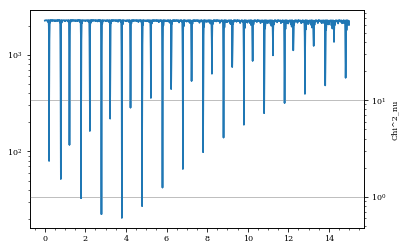

In [30]:
# =============================================================================
# #statistical tests
# =============================================================================

#Chi2 test 
chi2,chi2_nu=LS_chi2(t_obs,dy1,y_obs1,omega,phase,A,B)

#### 2.2. Bootstrap histogram and error estimation:

In order to estimate the uncertainty we can use a bootstrap. For this we construct a mock data set with the same length as the observed by ramdoly draw pairs of $(t_i,y_i)$ with repitition from the observed sample. Then compute the periodogram for each mock sample and save the highest peak. 

By doing this we ar virtually repeating the same experiment several times, because of the repitition in each of this (virual) experimnets (or universe) we give more weight to some observations (the repeated one). This remind me to Galileo, when he wrote in his notes the significance of his measurements based in the amount of wine he drank that night.

Is important to bear in mind that doing this random draw, in average, there are 1/3 of the points which will not being draw for each simulation. This has special relevance in time series analysis since not all the data points has the same importance.

In [31]:
D_err, omegaD_err = LS_bootstrap_err_est(t_obs, y_obs1, dy1, omega, generalized=True,
                           N_bootstraps=N_bootstraps, random_state=None,
                           hist=True,plot_hist=False,Nbins=len(omega))
frecD=omegaD_err/(2.0*np.pi)

NameError: name 'Nbins' is not defined

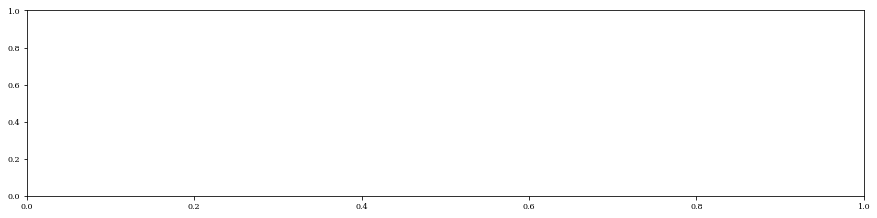

In [32]:
fig = plt.figure(figsize=(15, 7.5))
ax4 = fig.add_subplot(211)
#ax4.fill(omega, P_true, fc='gray', ec='gray')
#ax4.plot(omega, P_obs2, '-', c='black')
#ax4.text(0.96, 0.92, "Data PSD\n(50x errors)",
#        ha='right', va='top', transform=ax4.transAxes)
ax4.hist(frecD,normed=False,histtype='step',bins=Nbins,label='bootstrap',color='r')

ax3 = fig.add_subplot(212)
ax3.hlines(sig1,nu.min(),nu.max(),linestyles='-.',colors='r',alpha=0.5)
##ax3.hlines(sig1W,omega.min(),omega.max(),linestyles='--',colors='g',alpha=0.5)
ax3.hlines(sig1S,nu.min(),nu.max(),linestyles=':',colors='b',alpha=0.5)
#ax3.fill(omega, P_true, fc='gray', ec='gray')
ax3.plot(nu, P_obs1, '-', c='black')
#ax3.plot(omega, P_window, '-', c='r',alpha=0.7)
ax3.text(0.96, 0.92, "Data PSD", ha='right', va='top', transform=ax3.transAxes)
ax3.set_ylim(-0.1, 1.01)
ax3.set_xlabel('$f$')
ax3.set_ylabel(r'$P_{\rm LS}(f)$')
ax3.annotate(str(round(frec_guess,2))+"", (frec_guess, np.max(P_obs1)*1.02), (frec_guess, np.max(P_obs1)*1.1), ha='right',
             arrowprops=dict(arrowstyle='->'))

ax32 = ax3.twinx()
ax32.set_ylim(tuple(lomb_scargle_BIC(ax3.get_ylim(), y_obs1, dy1)))
ax32.set_ylabel(r'$\Delta BIC$')

## Preparing the figures

First we fold the signal

In [ ]:
#------------------------------------------------------------
#Fold signal
foldt = (frec*t_obs)%1 

In [ ]:
# =============================================================================
# # Prepare the figures
# =============================================================================
omega /= 2 * np.pi


fig = plt.figure(figsize=(15, 7.5))
fig.subplots_adjust(bottom=0.075, hspace=0.235, wspace=0.095,
                    top=0.960, left=0.045, right=0.975)

fig.suptitle(str(Nobs)+' observations, frec='+str(round(frec,2))+
             
             ' |')

ax1 = fig.add_subplot(311)
ax1.errorbar(t_obs, y_obs1, dy1, fmt='.k', capsize=1, ecolor='#444444')
ax1.plot(t,A*np.sin((2.*np.pi*frec_guess* t) + phase)+B)
ax1.text(0.96, 0.92, "Data", ha='right', va='top', transform=ax1.transAxes)
ax1.set_ylim(-60, 68)
ax1.set_xlim(0,20)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$y(t)$')

ax2 = fig.add_subplot(325)
ax2.plot(omega, P_window, '-', c='black')
ax2.text(0.96, 0.92, "Window PSD", ha='right', va='top', transform=ax2.transAxes)
ax2.set_ylim(-0.1, 1.01)
ax2.set_xlabel('$f$')
ax2.set_ylabel(r'$P_{\rm LS}(f)$')

ax3 = fig.add_subplot(324)
ax3.hlines(sig1,omega.min(),omega.max(),linestyles='-.',colors='r',alpha=0.5)
##ax3.hlines(sig1W,omega.min(),omega.max(),linestyles='--',colors='g',alpha=0.5)
ax3.hlines(sig1S,omega.min(),omega.max(),linestyles=':',colors='b',alpha=0.5)
#ax3.fill(omega, P_true, fc='gray', ec='gray')
ax3.plot(omega, P_obs1, '-', c='black')
#ax3.plot(omega, P_window, '-', c='r',alpha=0.7)
ax3.text(0.96, 0.92, "Data PSD", ha='right', va='top', transform=ax3.transAxes)
ax3.set_ylim(-0.1, 1.01)
ax3.set_xlabel('$f$')
ax3.set_ylabel(r'$P_{\rm LS}(f)$')
ax3.annotate(str(round(frec_guess,2))+"", (frec_guess, np.max(P_obs1)*1.02), (frec_guess, np.max(P_obs1)*1.1), ha='right',
             arrowprops=dict(arrowstyle='->'))

ax32 = ax3.twinx()
ax32.set_ylim(tuple(lomb_scargle_BIC(ax3.get_ylim(), y_obs1, dy1)))
ax32.set_ylabel(r'$\Delta BIC$')


ax4 = fig.add_subplot(3,2,6)
#ax4.fill(omega, P_true, fc='gray', ec='gray')
#ax4.plot(omega, P_obs2, '-', c='black')
#ax4.text(0.96, 0.92, "Data PSD\n(50x errors)",
#        ha='right', va='top', transform=ax4.transAxes)
ax4.hist(frecD,normed=False,histtype='step',bins=Nbins,label='bootstrap',color='r')
#ax4.hist(frecD_wind,normed=True,histtype='step',bins=Nbins,label='bootstrap',color='g')
#ax4.hist(frecD_shuff,normed=True,histtype='step',bins=Nbins,label='bootstrap',color='b')

#ax4.set_ylim(-0.1, 1.1)
ax4.set_xlabel('$f[d^{-1}]$')
#ax4.set_ylabel(r'$P_{\rm LS}(f)$')


ax5 = fig.add_subplot(3,4,5)
ax5.errorbar(foldt,y_obs1,dy1, fmt='.k', capsize=1, ecolor='#444444',alpha=0.7)
ax5.errorbar(1+foldt[foldt<0.1],y_obs1[foldt<0.1],dy1[foldt<0.1], fmt='.k', capsize=1, ecolor='#444444',alpha=0.7)
#ax5.plot(t[t<1.1],A*np.sin(t[t<1.1]*2*np.pi),linewidth=2)
             
ax6 = fig.add_subplot(3,4,6)
Xcum_BS=np.sort(D)
Ycum=np.array(range(1,N_bootstraps+1))/float(N_bootstraps)
ax6.plot(Xcum_BS,Ycum,'r-.',label='bootstrap ('+str(round(sig5,2))+','+str(round(sig1,2))+')')
##Xcum_W=np.sort(Wind_D)
##ax6.plot(Xcum_W,Ycum,'g--',label='normal ('+str(round(sig5W,2))+','+str(round(sig1W,2))+')')
Xcum_S=np.sort(shuff_D)
ax6.plot(Xcum_S,Ycum,'b:',label='shuffle ('+str(round(sig5S,2))+','+str(round(sig1S,2))+')')
#ax6.vlines(sig1,0,1,colors='b')
#ax6.xlim(Xcum,Xcum)
ax6.grid()
ax6.minorticks_on()
ax6.set_xlabel('$P_{LS}$')

ax6.legend(loc='best')

plt.show()



## Modeling the statistical Significance test
In order to obtain the probability of have a power greater or equal to the maximoum power obtained in the periodogram we need to fit the distribution function of the values obtained in in our simulations.

### Weibull: the distribution function of bootstrapping and null hypotesis test

The Weibull distribution is the most commonly used distribution for modeling reliability data or “survival” data. It has two parameters, which allow it to handle increasing, decreasing or constant failure-rates. It is defined as 

$f(x)= $
$k \frac{x^{k-1}}{\lambda^k}$
$e^{-(x/\lambda)^k} ;\ \forall x \in (0,\inf)$

where $k > 0$ is the shape parameter and $λ>0$ is the scale parameter of the distribution. Its complementary cumulative distribution function is a stretched exponential function.

If the quantity x is a “time-to-failure”, the Weibull distribution gives a distribution for which the failure rate is proportional to a power of time. The shape parameter, k, is that power plus one, and so this parameter can be interpreted directly as follows:

 - A value of k < 1 indicates that the failure rate decreases over time. This happens if there is significant “infant mortality”, or defective items failing early and the failure rate decreasing over time as the defective items are weeded out of the population.
 - A value of k = 1 indicates that the failure rate is constant over time. This might suggest random external events are causing mortality, or failure.
 - A value of k > 1 indicates that the failure rate increases with time. This happens if there is an “aging” process, or parts that are more likely to fail as time goes on.

In the field of materials science, the shape parameter k of a distribution of strengths is known as the Weibull modulus.

![title](Weibull_PDF.png)

text from <url>http://work.thaslwanter.at/Stats/html/statsDistributions.html
    
other usefull links:
    
    [scipy](https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html)
    
    [stack overflow](https://stackoverflow.com/questions/17481672/fitting-a-weibull-distribution-using-scipy)
    
### Fitting the distribution
Now we are ready to fit the data set as follow:

In [ ]:
#–-------------------------------------------------------------------
#fitting CDF


#from scipy.stats import exponweib as weibull
from scipy import stats

power=np.arange(0,1.00001,0.00001) #defining the power array

#estimating the parameters of weibull function for each method
p_BS=stats.exponweib.fit(Xcum_BS, 1, 1, scale=02, loc=0) 
p_S=stats.exponweib.fit(Xcum_S, 1, 1, scale=02, loc=0)
##p_W=stats.exponweib.fit(Xcum_W, 1, 1, scale=02, loc=0)

Plotting the function and probablity values for the maximun power of the periodogram.

In [ ]:
fig2 = plt.figure(figsize=(15, 7.5))
fig2.subplots_adjust(bottom=0.075, hspace=0.235, wspace=0.095,
                    top=0.960, left=0.045, right=0.975)
fig2.suptitle('MODEL: WEIBULL DISTRIBUTION')

#fig2 = plt.figure('CDF')
ax = fig2.add_subplot(221)
ax.set_title('CDF')
##ax.plot(Xcum_W,Ycum,'yx', label='white noise',alpha=0.5)
ax.plot(Xcum_BS,Ycum,'kx', label='bootstrap')
ax.plot(Xcum_S,Ycum,'bx', label='null test')
##ax.plot(power,stats.exponweib.cdf(power,p_W[0],p_W[1],p_W[2],p_W[3]), 'b')
ax.plot(power,stats.exponweib.cdf(power,p_BS[0],p_BS[1],p_BS[2],p_BS[3]), 'g')
ax.plot(power,stats.exponweib.cdf(power,p_S[0],p_S[1],p_S[2],p_S[3]), 'r')

ax.legend(loc='best')
ax.set_xlabel('Lomb Scargle Power')


#fig2 = plt.figure('PDF')
ax = fig2.add_subplot(222)
ax.set_title('PDF')
##plt.hist(Xcum_W, bins=np.linspace(0, 1, 40), normed=True, alpha=0.5, label='white noise', color='b')
##plt.plot(Xcum_W, stats.exponweib.pdf(Xcum_W, *stats.exponweib.fit(Xcum_W, 1, 1, scale=02, loc=0)), color='b')

plt.plot(Xcum_BS, stats.exponweib.pdf(Xcum_BS, *stats.exponweib.fit(Xcum_BS, 1, 1, scale=02, loc=0)), color='k')
plt.hist(Xcum_BS, bins=np.linspace(0, 1, 40),normed=True, alpha=0.5, label='bootstrap', color='k')

plt.plot(Xcum_S, stats.exponweib.pdf(Xcum_S, *stats.exponweib.fit(Xcum_S, 1, 1, scale=02, loc=0)), color='b')
plt.hist(Xcum_S, bins=np.linspace(0, 1, 40), normed=True, alpha=0.5, label='null test', color='b')

ax.legend(loc='best')
ax.set_xlabel('Lomb Scargle Power')


#fig2 = plt.figure('SF')
ax = fig2.add_subplot(212)
ax.set_title('Survival function (1-CDF)')
##ax.plot(Xcum_W,1-Ycum,'yx', label='white noise',alpha=0.5)
ax.plot(Xcum_BS,1-Ycum,'kx', label='bootstrap')
ax.plot(Xcum_S,1-Ycum,'bx', label='null test')
##ax.plot(power,stats.exponweib.sf(power,p_W[0],p_W[1],p_W[2],p_W[3]), 'b')
ax.plot(power,stats.exponweib.sf(power,p_BS[0],p_BS[1],p_BS[2],p_BS[3]), 'r')
ax.plot(power,stats.exponweib.sf(power,p_S[0],p_S[1],p_S[2],p_S[3]), 'g')

prob_Pmax_S=stats.exponweib.sf(P_max,p_S[0],p_S[1],p_S[2],p_S[3])
prob_Pmax_BS=stats.exponweib.sf(P_max,p_BS[0],p_BS[1],p_BS[2],p_BS[3])

ax.hlines(prob_Pmax_BS,power.min(),P_max)
ax.vlines(P_max,1e-15,prob_Pmax_BS)
ax.hlines(prob_Pmax_S,power.min(),P_max)
ax.vlines(P_max,1e-15,prob_Pmax_S)

ax.legend(loc='best')
#ax.set_xscale('log')
ax.set_yscale('log')

ax.text(0.05, 0.3, "$max(P_{LS})="+str(np.round(P_max,3))+'$\n'\
        +'Bootstrap Prob='+str(prob_Pmax_BS)+'\n'\
        +'Null Hyp Prob='+str(prob_Pmax_S),\
        ha='left', va='bottom', transform=ax.transAxes)
        


print('The probability of obtain by chance a power of '+str(np.max(P_obs1))+\
      ' by testing the null hypotesis is:')
print(prob_Pmax_S)

print('The probability of obtain by chance a power of '+str(np.max(P_obs1))+\
      ' by testing the bootstrap significance is:')
print(prob_Pmax_BS)


In [ ]:
frecD_BSS=omegaD/(2.0*np.pi)
frecD_null=shuff_omegaD/(2.0*np.pi)
f = plt.figure(figsize=(15, 7.5))
ax6 = f.add_subplot(111)
ax6.hist(frecD_BSS,normed=False,histtype='step',bins=Nbins,label='bootstrap',color='r')
ax6.hist(frecD_null,normed=False,histtype='step',bins=Nbins,label='null',color='b')
ax6.grid()
ax6.minorticks_on()
ax6.set_xlabel('$P_{LS}$')
ax6.set_title('Significance test frecuencies histogram')

ax6.legend(loc='best')